**Step 1: Installing and Importing all the necessary Libraries**

In [1]:
# Install necessary libraries (if not already installed)
!pip install datasets torch torchvision torchaudio nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:

# Import libraries
import torch
import pandas as pd
import numpy as np
import nltk
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Dataset
**Step 2: Loading the dataset from Hugging Face and inserting it into Pandas**

In [3]:
# Loading the dataset from Hugging Face
dataset = load_dataset("Ateeqq/AI-and-Human-Generated-Text")

# Convert dataset splits to Pandas DataFrames
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# Renaming the dataset to match and putting them in new train and test variables
train_df = train_df.rename(columns={"abstract": "text", "label": "label"})
test_df = test_df.rename(columns={"abstract": "text", "label": "label"})


#Splitting the datasets into training anf validation sets with a 2:8 ratio
train_data = train_df.sample(frac=0.8, random_state=42)
val_data = train_df.drop(train_data.index)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_df)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22930 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5732 [00:00<?, ? examples/s]

Train Size: 18344, Validation Size: 4586, Test Size: 5732


#Data Analysis
**Step 3: Tokenization of the data using TinyBERT**

TinyBERT has a reduced model size which allows faster computational speed and reduced memory usage compared to the original BERT model.
Plus, it provides higher efficiency as well in terms of performance.

AdamW is the chosen optimizer as it provides faster learning rate from different portions of the model which makes the understanding much easier and smoother.



In [4]:
# Loading the TinyBERT model
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", model_max_length=128)


# Defining PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
      #We store the data as a list for easier access and also save the tokenizer
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
      #The data at any given parameter index can be tokenized
        encoding = self.tokenizer(self.texts[idx],
                                  truncation=True, #ensures sequences longer than 'model_max_length' are shortened.
                                  padding="max_length", #adds padding to shorter sequences to match 'model_max_length'.
                                  return_tensors="pt")  #returns PyTorch tensors.
        return {
            "input_ids": encoding["input_ids"].squeeze(), #removes unnecessary dimensions
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx])
        }

# Create dataset objects
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)
test_dataset = TextDataset(test_df, tokenizer)

# Create DataLoaders
BATCH_SIZE = 8  # Reduce batch size if RAM issues occur
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check a batch
for batch in train_loader:
    print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["label"].shape)
    break


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

torch.Size([8, 128]) torch.Size([8, 128]) torch.Size([8])


**Step 3: Defining the TinyBERT Model in more details followed by Training it**

In [5]:
# Define TinyBERT classification model
class TinyBERTClassifier(nn.Module):
    def __init__(self, model_name="huawei-noah/TinyBERT_General_4L_312D", num_classes=2):
        super(TinyBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)  # Prevents overfitting
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Classification layer

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        return self.fc(self.dropout(pooled_output))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyBERTClassifier().to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

#Data Classification
**Step 4: Training the Model and Validating it at the same time**

In [6]:
def train(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        #Tracking of the losses, correct outputs and the total number of samples
        total_loss, correct, total = 0, 0, 0

        #The epoch number is printed each time in order to ensure the code is not hanged
        print(f"\nEpoch {epoch + 1}/{epochs}...")

        for batch in train_loader:
          #The input IDs are tokenizers used here to be fed into the model and they are also used as the references when lookin up through the vocabs
          #The Attention Mask is for handling padding and to
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        validate(model, val_loader)

def validate(model, val_loader):
    model.eval()
    # Initialize counters for correct predictions and total samples
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
          # Shift the input tensors to the correct required devices
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            outputs = model(input_ids, attention_mask)
            correct += (outputs.argmax(1) == labels).sum().item() #Comparison of the predicted 'outputs' with the original labels
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

# Train the model
train(model, train_loader, val_loader, 10)



Epoch 1/10...


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Train Loss: 0.1166, Accuracy: 0.9557
Validation Accuracy: 0.9882

Epoch 2/10...
Train Loss: 0.0397, Accuracy: 0.9862
Validation Accuracy: 0.9754

Epoch 3/10...
Train Loss: 0.0240, Accuracy: 0.9915
Validation Accuracy: 0.9817

Epoch 4/10...
Train Loss: 0.0161, Accuracy: 0.9951
Validation Accuracy: 0.9850

Epoch 5/10...
Train Loss: 0.0135, Accuracy: 0.9953
Validation Accuracy: 0.9884

Epoch 6/10...
Train Loss: 0.0071, Accuracy: 0.9979
Validation Accuracy: 0.9878

Epoch 7/10...
Train Loss: 0.0076, Accuracy: 0.9974
Validation Accuracy: 0.9898

Epoch 8/10...
Train Loss: 0.0065, Accuracy: 0.9984
Validation Accuracy: 0.9832

Epoch 9/10...
Train Loss: 0.0064, Accuracy: 0.9980
Validation Accuracy: 0.9887

Epoch 10/10...
Train Loss: 0.0052, Accuracy: 0.9987
Validation Accuracy: 0.9874


In [7]:
def evaluate(model, loader, return_preds=False):
  #This is when the learning stops and the evaluation begins. Which also means, the drop off is turned off and provides batch normalization for consistent results
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, label = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.argmax(1).tolist())
            labels.extend(label.tolist())

    if return_preds: # Return predictions if return_preds is True
        return predictions
    else:
        return accuracy_score(labels, predictions) # Otherwise, return accuracy

print("Final Test Accuracy:", evaluate(model, test_loader))


Final Test Accuracy: 0.9891835310537335


In [8]:
# Convert dataset into Pandas DataFrame
train_texts = train_data["text"].tolist()
val_texts = val_data["text"].tolist()
test_texts = test_df["text"].tolist()

train_labels = train_data["label"].tolist()
val_labels = val_data["label"].tolist()
test_labels = test_df["label"].tolist()

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print("TF-IDF feature extraction completed.")


TF-IDF feature extraction completed.


In [9]:
# Train logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, train_labels)

# Predict on validation and test sets
val_pred_logreg = log_reg_model.predict(X_val_tfidf)
test_pred_logreg = log_reg_model.predict(X_test_tfidf)

# Evaluate performance
val_accuracy_logreg = accuracy_score(val_labels, val_pred_logreg)
test_accuracy_logreg = accuracy_score(test_labels, test_pred_logreg)

print(f"Logistic Regression Validation Accuracy: {val_accuracy_logreg:.4f}")
print(f"Logistic Regression Test Accuracy: {test_accuracy_logreg:.4f}")


Logistic Regression Validation Accuracy: 0.9782
Logistic Regression Test Accuracy: 0.9745


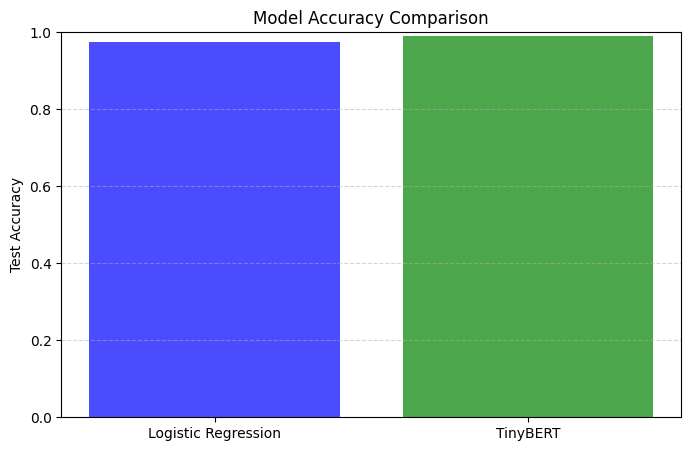

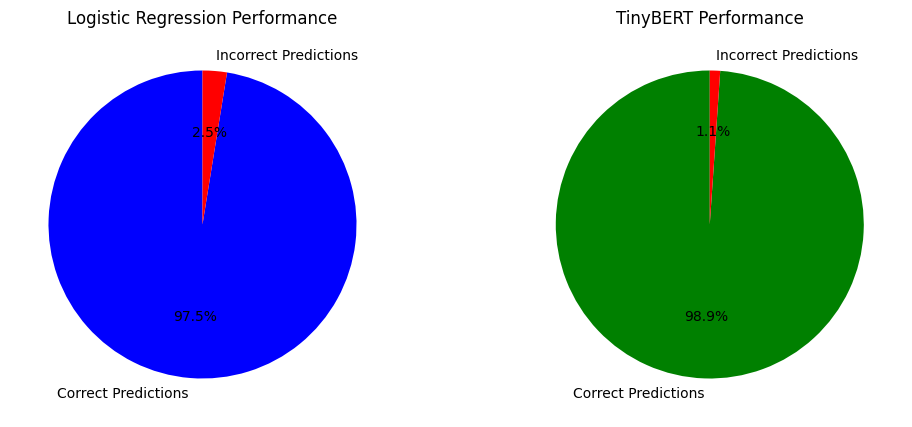

In [10]:
# Evaluate TinyBERT
tinybert_test_accuracy = evaluate(model, test_loader)

# Calculate classification reports
logreg_report = classification_report(test_labels, test_pred_logreg, output_dict=True)
tinybert_report = classification_report(test_labels, evaluate(model, test_loader, return_preds=True), output_dict=True)

# Extract accuracy scores
models = ["Logistic Regression", "TinyBERT"]
accuracies = [test_accuracy_logreg, tinybert_test_accuracy]

# 🔹 Bar Chart: Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'], alpha=0.7)
plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 🔹 Pie Charts: Classification Report Breakdown
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get precision, recall, f1-score
logreg_f1 = logreg_report["weighted avg"]["f1-score"]
tinybert_f1 = tinybert_report["weighted avg"]["f1-score"]

# Create pie chart data
labels = ['Correct Predictions', 'Incorrect Predictions']
logreg_pie = [logreg_f1, 1 - logreg_f1]
tinybert_pie = [tinybert_f1, 1 - tinybert_f1]

# Pie Chart for Logistic Regression
axes[0].pie(logreg_pie, labels=labels, autopct='%1.1f%%', colors=['blue', 'red'], startangle=90)
axes[0].set_title("Logistic Regression Performance")

# Pie Chart for TinyBERT
axes[1].pie(tinybert_pie, labels=labels, autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title("TinyBERT Performance")

plt.show()

Based on the above diagrams of the graphs and the pie charts, It is easily visible by the labels how much better the TinyBERT is at accuracy of correct predictions.
Although using the Logistic Regression would have had a good accuracy as well but the TRAINED TinyBERT model proved to show slightly better results.
Plus with the number of epochs increased from 3(default) to 10, the accuracy results have increased and if the number of epochs is increased further, then the accuracy will increase even more and sometimes to the point where the value of the accuracy would even be 1, that is, 100% correct.

The graphical representation would showcase the result to have anyone running the code, to get a clear grasp and view of how much % difference both the models show.

In [12]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.8 MB/s eta 0:00:00


In [ ]:
# Download the required NLTK resource
nltk.download('averaged_perceptron_tagger_eng')

from nlpaug.augmenter.word import SynonymAug

augmenter = SynonymAug(aug_p=0.3)  # Replace 30% of words with synonyms

# Access the 'train' split of the dataset and then the 'abstract' column (instead of 'text')
augmented_texts = [augmenter.augment(text) for text in dataset['train']['abstract']]
dataset['train'] = dataset['train'].add_column("augmented_text", augmented_texts)

# Similarly for the 'test' split
augmented_texts_test = [augmenter.augment(text) for text in dataset['test']['abstract']]
dataset['test'] = dataset['test'].add_column("augmented_text", augmented_texts_test)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
